# Focus on Sinkhorn

We provide in this example a detailed walk-through some of the functionalities of the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm, including the computation of {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import functools
import time

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import ott
from ott import problems
from ott.geometry import geometry, pointcloud
from ott.solvers import linear
from ott.solvers.linear import acceleration, sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

## From texts to word histograms

We adapt a [keras NLP tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/) to preprocess raw text (here a subset of texts from the [newsgroup20](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) database) and turn them into word embeddings histograms; see [here](https://colab.research.google.com/drive/1uCK_qBpOb8yY32ABU_GcykSKE-Q-yjfi) for detailed preprocessing.

This helps us recover 635 histograms supported on 4000 words, each represented by a 50-dimensional vector. We download that data using an url

In [3]:
import io

import requests

import numpy as np

response = requests.get("https://marcocuturi.net/embeddings.npz")
data = np.load(io.BytesIO(response.content))

In [4]:
X, HIST = data.get("X"), data.get("HIST")

In [5]:
# X contains 4000 word embeddings in dimension 50 , HIST a 653 x 4000 (row-normalized) matrix of histograms.
print(
    f"{HIST.shape[0]} texts supported on up to {HIST.shape[1]} words of dimension {X.shape[1]}"
)

653 texts supported on up to 4000 words of dimension 50


## Pairwise Sinkhorn divergences

Before setting a value for `epsilon`, let's get a feel of what the {class}`~ott.geometry.pointcloud.PointCloud` of embeddings looks like in terms of distances.

In [6]:
geom = pointcloud.PointCloud(X)
print(
    "median cost:",
    geom.median_cost_matrix,
    " mean cost:",
    geom.mean_cost_matrix,
)

median cost: 0.4035166  mean cost: 0.41272438


We can also store this $4000 \times 4000$ cost matrix, once and for all, because its size is still reasonable.

In [7]:
cost = geom.cost_matrix
print(" max:", jnp.max(geom.cost_matrix))

 max: 1.4388261


When setting `epsilon` to `None`, the algorithms will default to $0.05$ of the mean distance described in the geometry. This is no magical number, but rather a simple statistic of the scale of the problem. We recommend that you tune `epsilon` by yourself, but using `None` might avoid common issues (such as running {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` with a very small `epsilon` while the cost matrices are large).

In [8]:
print("Default epsilon is: ", geom.epsilon)

Default epsilon is:  0.02063622


Based on this, we simply set `epsilon` to 1e-2

In [9]:
epsilon = 1e-2

We can now make a simple test run, and compute a regularized optimal transport cost between a few histograms.

As we see below, the number of iterations to solve such problems, for that level of `epsilon`, ranges anywhere from 1 to 2 digits.

In [10]:
n_iters = []
for i in range(13):
    n_iters.append(
        linear.solve(
            geometry.Geometry(cost_matrix=cost, epsilon=epsilon),
            lse_mode=False,
            a=HIST[0, :],
            b=HIST[1 + i, :],
        ).n_iters
    )
print(np.array(n_iters))

[290  60  70  90 120 100 120 120  80  70  80 110 100]


We now define a {func}`jitted <jax.jit>` and parallel version of the {func}`~ott.solvers.linear.sinkhorn.Sinkhorn` solver. We first define a convenience wrapper that computes the regularized OT cost of a problem defined by histograms `a`, `b`, a `cost` and `epsilon` regularization. For reasons that will become obvious later, we also provide explicitly a minimum and maximum number of iterations for the Sinkhorn algorithm.

In [11]:
def sink(a, b, cost, epsilon, min_iterations, max_iterations):
    return linear.solve(
        geometry.Geometry(cost_matrix=cost, epsilon=epsilon),
        a=a,
        b=b,
        lse_mode=False,
        min_iterations=min_iterations,
        max_iterations=max_iterations,
    ).reg_ot_cost

We can now use a *double* {func}`~jax.vmap`, to compute in one go the pairwise matrix of regularized OT costs between two sets of histograms. The `0` placed in the first arguments of these `vmap` refer to the batch dimensions. Note how the `out_axis` of the first and second call differ, to recover respectively a matrix of the same size as the batches we will use.


Jitting is super important to achieve efficiency, don't forget to wrap whatever you do with a {func}`~jax.jit`.

In [12]:
sink_div_2vmap = jax.jit(
    jax.vmap(jax.vmap(sink, [0] + [None] * 5, 0), [None, 0] + [None] * 4, 1),
    static_argnums=[4, 5],
)

Compute now a pairwise $44 \times 37$ matrix of Sinkhorn divergences (about 1000 divergences in total). We pick 30 different texts twice.

In [13]:
HIST_a = jnp.array(HIST[0:45])
HIST_b = jnp.array(HIST[-37:])
print(HIST_a.shape, HIST_b.shape, cost.shape)

(45, 4000) (37, 4000) (4000, 4000)


Dry run with large epsilon value to force {func}`~jax.jit` compilation before computing timings. This only makes sense within this tutorial.

In [14]:
DIV = sink_div_2vmap(HIST_a, HIST_b, cost, 1, 0, 100)

We now carry out divergence computations and plot their matrix for various `epsilon`.

In [15]:
DIV, ran_in = [], []
epsilons = [None, 1e-2, 1e-1]
for epsilon in epsilons:
    tic = time.perf_counter()
    DIV.append(
        sink_div_2vmap(
            HIST_a, HIST_b, cost, epsilon, 0, 100
        ).block_until_ready()
    )
    toc = time.perf_counter()
    ran_in.append(toc - tic)

Notice how smaller `epsilon` has a huge impact on time (far longer). Larger `epsilon` values result in less spiked values with, however, a similar relative pattern.

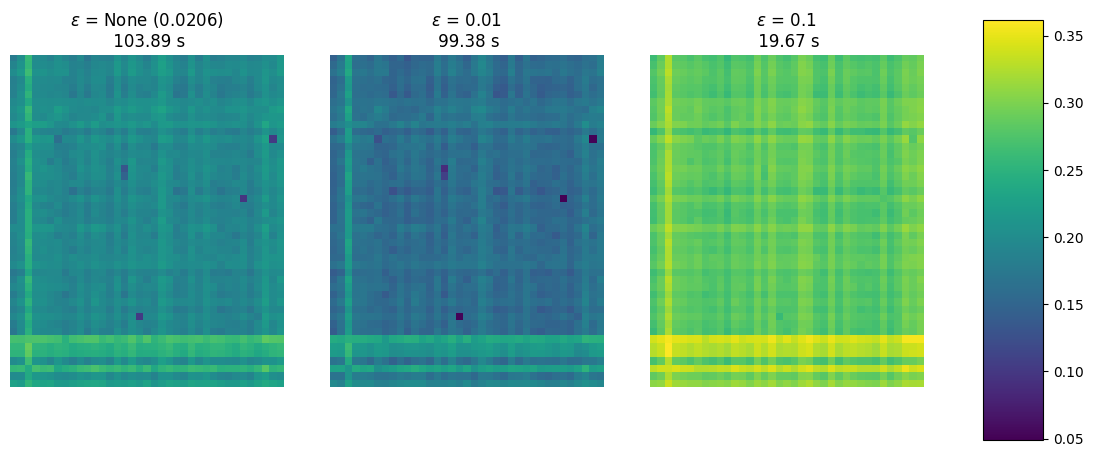

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.tight_layout()
axes = [axes[0], axes[1], axes[2]]
vmin = min([jnp.min(div) for div in DIV])
vmax = max([jnp.max(div) for div in DIV])

for epsilon, DIV_, ran_in_, ax_ in zip(epsilons, DIV, ran_in, axes):
    im = ax_.imshow(DIV_, vmin=vmin, vmax=vmax)
    eps = f" ({geom.epsilon:.4f})" if epsilon is None else ""
    ax_.set_title(
        r"$\varepsilon$ = " + str(epsilon) + eps + f"\n {ran_in_:.2f} s"
    )
    ax_.axis("off")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

While the double `vmap` above resulted in parallel executions, these runs use different termination criteria, which messes up with effective compilation. **This can be extremely detrimental to performance**.  

If you are aiming for speed when computing multiple distances in parallel, it is crucial to set the same number of iterations for each of them to help the XLA compiler.

In the first run below, the compiler cannot manager to parallelize efficiently these runs that differ in number of iterations:

In [17]:
epsilon = 1e-2
# Naive Vmapping
%time out_1 = DIV = sink_div_2vmap(HIST_a, HIST_b, cost, epsilon, 0, 100).block_until_ready()

CPU times: user 1min 37s, sys: 43.9 ms, total: 1min 37s
Wall time: 1min 37s


Here the compiler recognizes instantly that the Sinkhorn iterations can be run efficiently in parallel, as advocated originally in {cite}`cuturi:13`. This yields a 50x times speedup!!

In [18]:
# Vmapping while forcing the number of iterations to be fixed.
%time out_2 = DIV = sink_div_2vmap(HIST_a, HIST_b, cost, epsilon, 100, 100).block_until_ready()

CPU times: user 2.5 s, sys: 140 ms, total: 2.63 s
Wall time: 2.03 s


Because the number of iterations was chosen conservatively, we obtain exactly the same results.

In [19]:
jnp.linalg.norm(out_1 - out_2)

Array(1.42627105e-05, dtype=float32)

## The impact of $\varepsilon$ on convergence

We study in more detail how `epsilon` impacts the convergence of the algorithm. We define first a `my_sinkhorn` function to handle computations of {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` with suitable parameters for this notebook.

In [20]:
def my_sinkhorn(
    geom: geometry.Geometry, a: jnp.ndarray, b: jnp.ndarray, **kwargs
):
    return linear.solve(
        geom, a, b, inner_iterations=1, max_iterations=10_000, **kwargs
    )

We select now two text histograms. We will aim for texts that are supported on more than 1000 words each.

In [21]:
ind = jnp.argsort(jnp.sum(jnp.array(HIST) > 0, axis=1))
a, b = HIST[ind[-2]], HIST[ind[-1]]
print(
    f"Histogram `a` supported on {jnp.sum(a >0)} words, `b` on {jnp.sum(b >0)} words"
)

Histogram `a` supported on 1121 words, `b` on 1162 words


We start by looking more closely into the time needed for {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` to converge for various `epsilon` values.

In [22]:
out_eps, leg_eps = [], []
epsilons = [1e-3, 0.3 * 1e-2, 1e-2, 0.3 * 1e-1, 1e-1]
ran_in = np.zeros((len(epsilons),))
for i, epsilon in enumerate(epsilons):
    tic = time.perf_counter()
    out_eps.append(my_sinkhorn(geometry.Geometry(cost, epsilon=epsilon), a, b))
    toc = time.perf_counter()
    ran_in[i] = toc - tic
    leg_eps.append(
        r"$\varepsilon$"
        + f"= {epsilon}, reg_ot_cost = {out_eps[-1].reg_ot_cost:.2f}"
    )

These execution times can then be plotted, to result in the following graph:

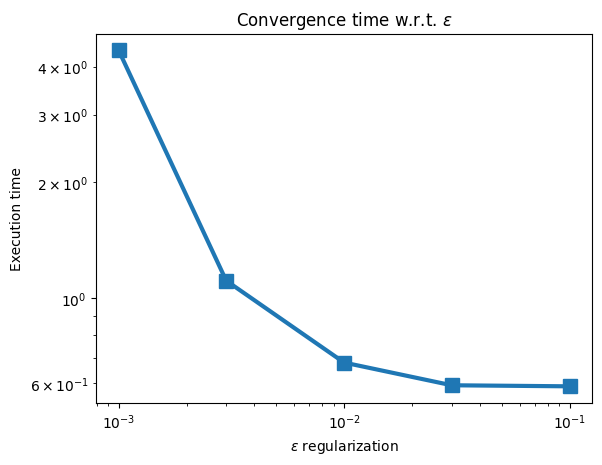

In [23]:
plt.plot(epsilons, ran_in, marker="s", markersize=10, linewidth=3)
plt.title(r"Convergence time w.r.t. $\varepsilon$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\varepsilon$ regularization")
plt.ylabel("Execution time")
plt.show()

We now take a closer look at the actual convergence curves of the error of the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm (i.e. marginal error). We introduce a `plot_results` function to visualize this convergence.

In [24]:
def plot_results(
    out, leg, loc="lower left", title="", xlabel="", ylabel="", ylim=(0.0005, 5)
):
    plt.figure(figsize=(12, 9))
    for out_ in out:
        plt.plot(out_.errors[out_.errors > -1], linewidth=3)
    plt.legend(leg, loc=loc)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(*ylim)
    plt.show()

We can now look more closely into `epsilon`'s impact. Obviously, the convergence is slower with smaller regularization: there is a trade-off between speed and how close to the original LP solution we want to be. In the absence of a strong opinion on how small regularization should, we advise that you start using larger `epsilon`, since this makes your life substantially easier!

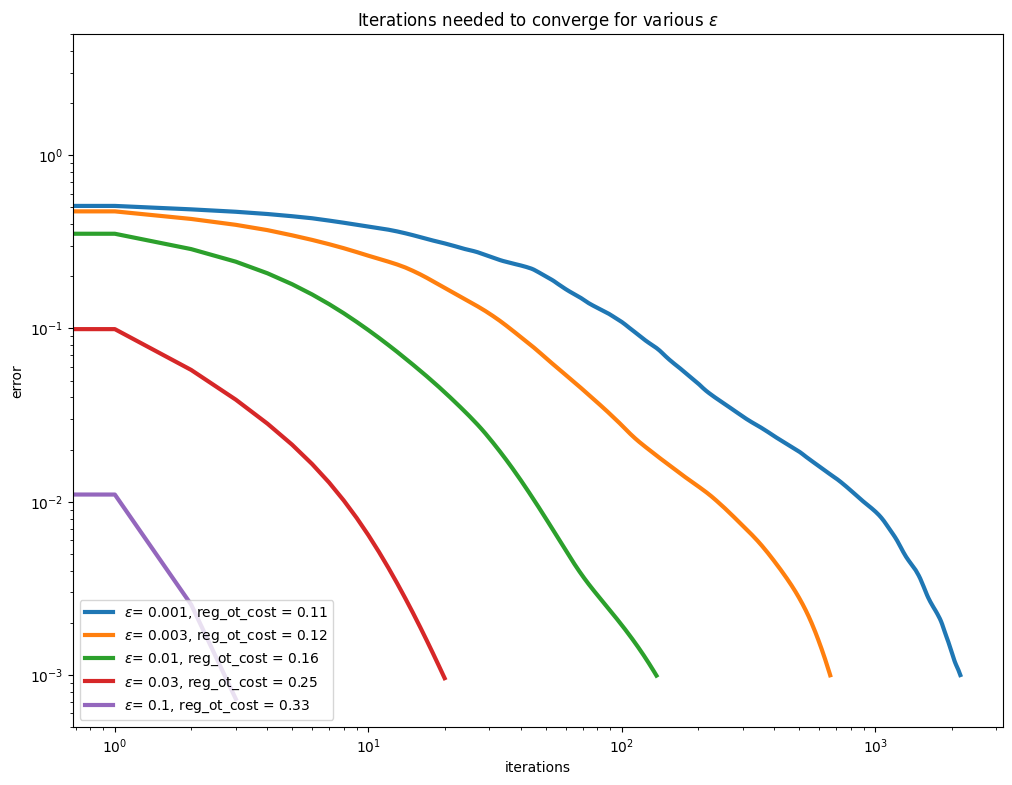

In [25]:
plot_results(
    out_eps,
    leg_eps,
    title=r"Iterations needed to converge for various $\varepsilon$",
    xlabel="iterations",
    ylabel="error",
)

## Speeding up Sinkhorn

### Fixed momentum

{cite}`thibault:21` proposed to use a {class}`~ott.solvers.linear.acceleration.Momentum` term to (hopefully) accelerate the convergence of the Sinkhorn algorithm. This is controlled by the `momentum` parameter when calling {class}`~ott.solvers.linear.sinkhorn.Sinkhorn`. We vary that parameter along with various `epsilon` regularization strengths. As can be seen below, a `momentum` parameter larger than 1.0 (also known as extrapolation or over-relaxation) helps, but can also be more unstable. 

We first compute baseline curves for three $\varepsilon$ values:

In [26]:
epsilons = [1e-4, 1e-3, 1e-2]
out_baseline, leg_baseline = [], []
for epsilon in epsilons:
    out_baseline.append(
        my_sinkhorn(geometry.Geometry(cost, epsilon=epsilon), a, b)
    )
    leg_baseline.append("Baseline")

Test now using ``momentum`` values lower and larger than 1. Run computations first

In [27]:
out_mom, leg_mom = [], []
for i, epsilon in enumerate(epsilons):
    out_mom.append([out_baseline[i]])  # initialize with baseline
    leg_mom.append([leg_baseline[i]])  # initialize with baseline
    for mom in [0.8, 1.05, 1.1, 1.3]:
        out_mom[i].append(
            my_sinkhorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                momentum=acceleration.Momentum(value=mom),
            )
        )
        leg_mom[i].append(f"Momentum : {mom}")

Plot them next. 

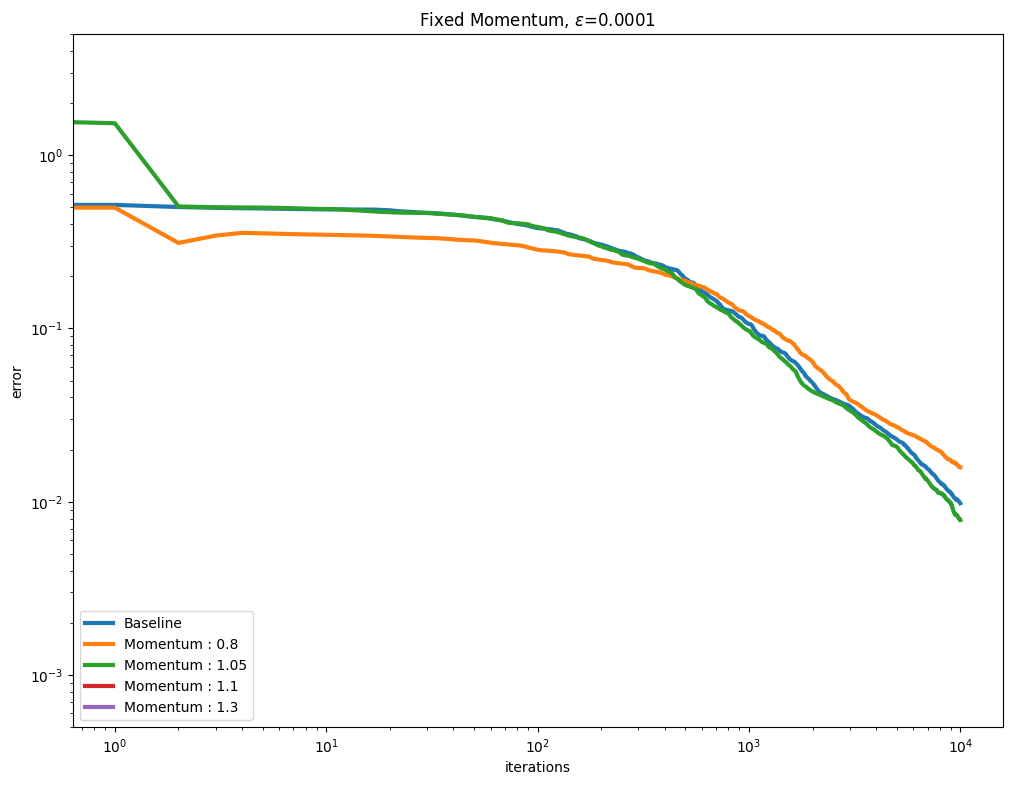

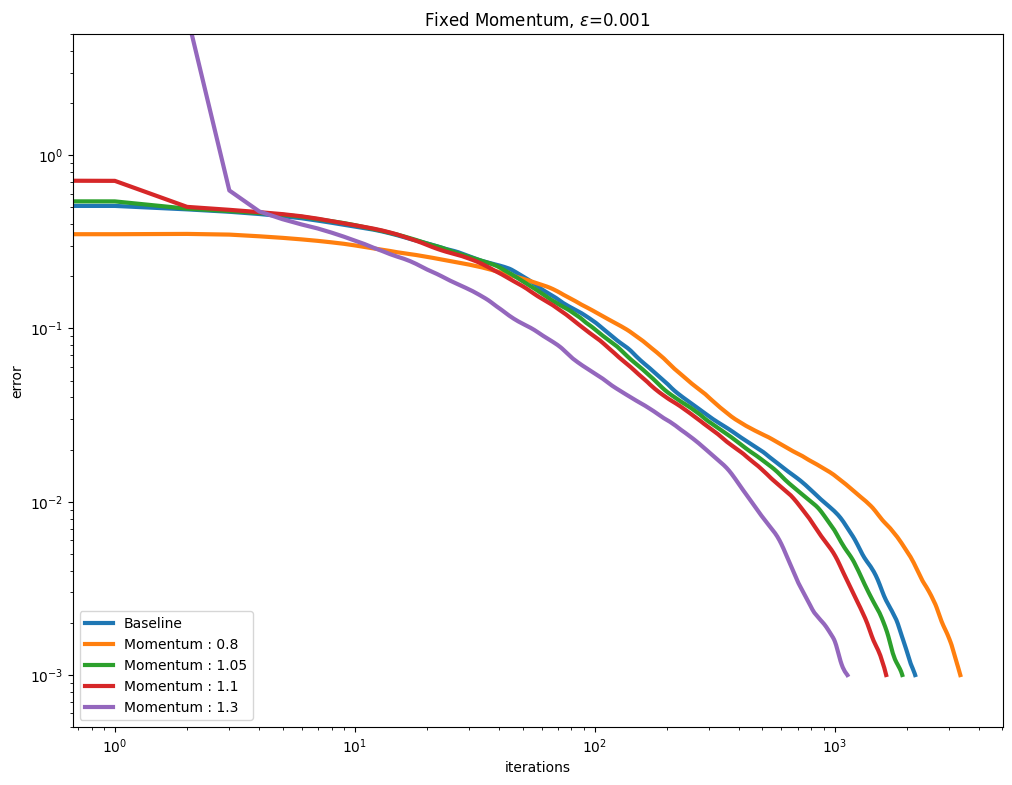

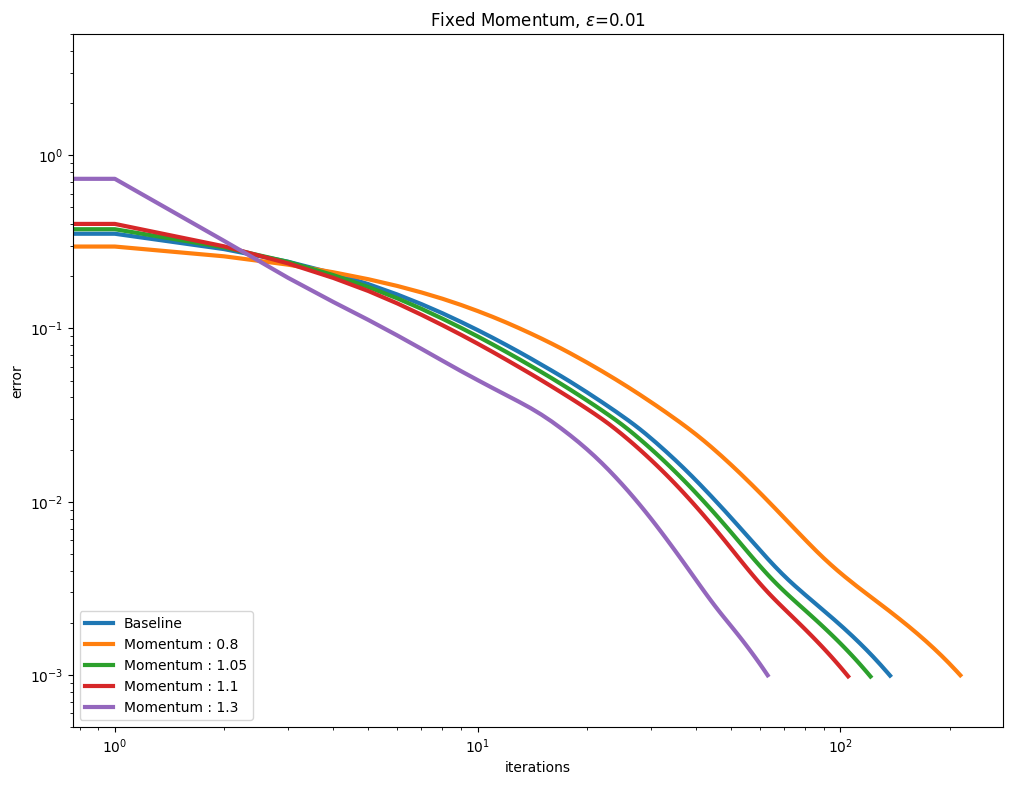

In [28]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_mom[i],
        leg_mom[i],
        title=r"Fixed Momentum, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

You might have noticed in the first set of curves that the values for `momentum` $1.1$ and $1.3$ are not displayed. For that small $\varepsilon=0.0001$,  the error has diverged from the first update.

In [29]:
[out_mom[0][3].errors], [
    out_mom[0][4].errors
]  # Computation diverges from first iteration for small epsilon, high momentum.

([Array([inf, -1., -1., ..., -1., -1., -1.], dtype=float32)],
 [Array([inf, -1., -1., ..., -1., -1., -1.], dtype=float32)])

### Adaptive momentum

{cite}`lehmann:21` propose a simple rule to update the {class}`~ott.solvers.linear.acceleration.Momentum` term adaptively, after a few {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` iterations, by tracking the convergence of the algorithm to compute a momentum parameter. We test this approach with various `epsilon` values.

In [30]:
out_chg_mom, leg_chg_mom = [], []
for i, epsilon in enumerate(epsilons):
    out_chg_mom.append([out_baseline[i]])
    leg_chg_mom.append([leg_baseline[i]])
    for chg_momentum_from in [10, 20, 50, 200, 1000]:
        out_chg_mom[i].append(
            my_sinkhorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                momentum=acceleration.Momentum(start=chg_momentum_from),
            )
        )
        leg_chg_mom[i].append(f"Change after {chg_momentum_from} it.")

As can be seen in the curves below, this seems to be a very effective and robust way to speed up the algorithm.

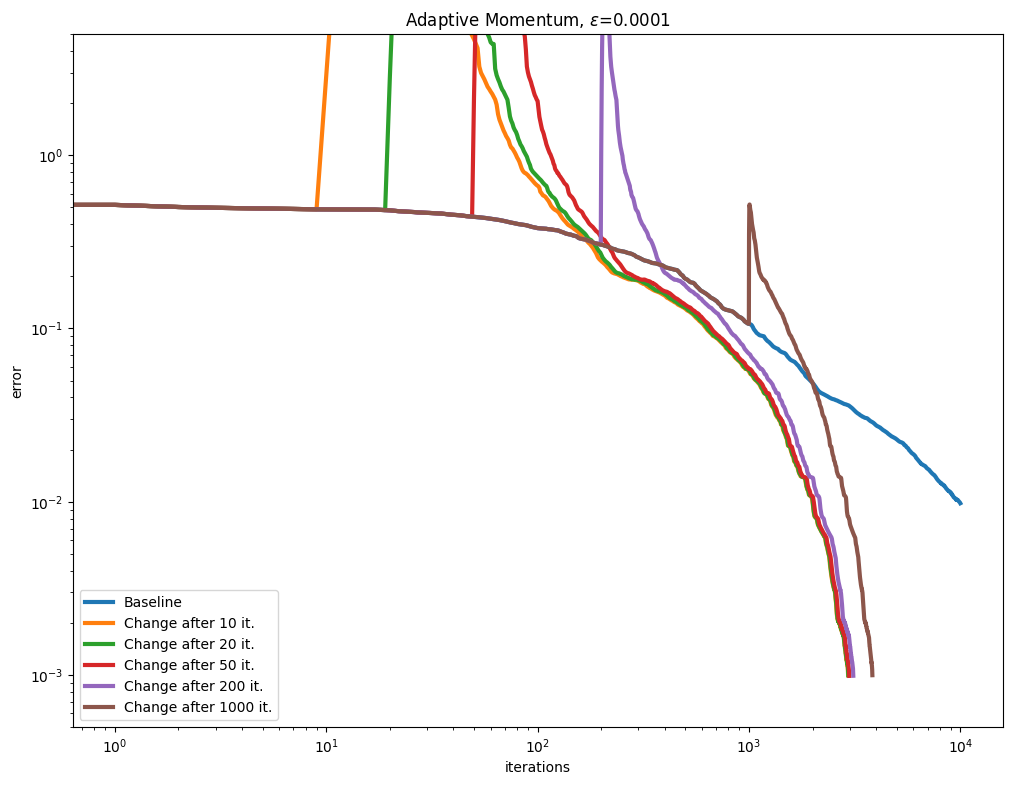

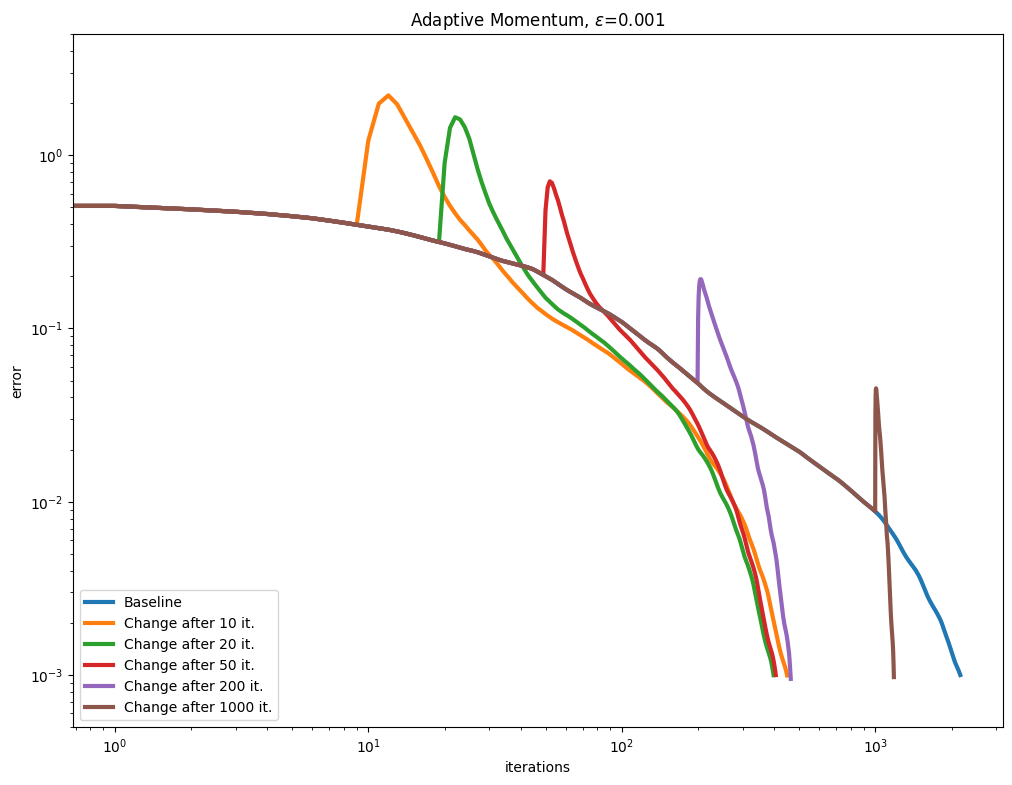

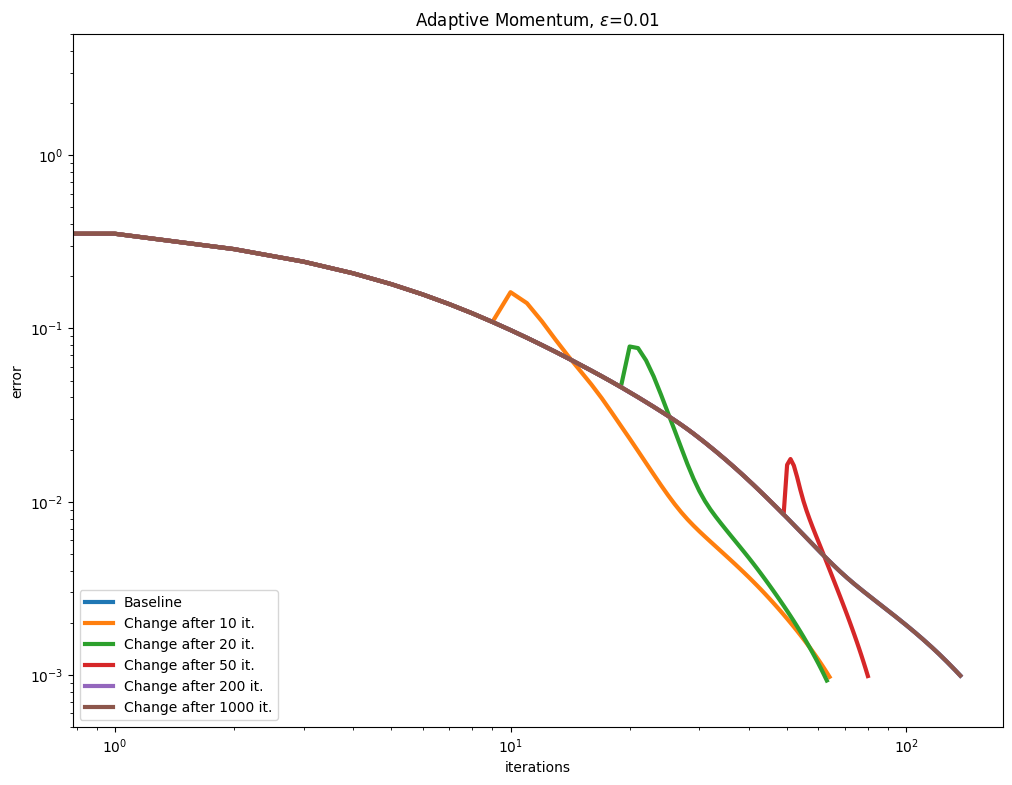

In [31]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_chg_mom[i],
        leg_chg_mom[i],
        title=r"Adaptive Momentum, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

### $\varepsilon$ decay

It also possible to use so called {class}`~ott.geometry.epsilon_scheduler.Epsilon` decay, which consists in starting the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` iterations with a large $\varepsilon$ value that is progressively decreased using a multiplicative update.

In [32]:
out_scaling, leg_scaling = [], []
for i, epsilon in enumerate(epsilons):
    out_scaling.append([out_baseline[i]])
    leg_scaling.append([leg_baseline[i]])
    for decay in [0.8, 0.95]:
        for init in [5, 50, 100]:
            Epsilon = geometry.epsilon_scheduler.Epsilon(
                target=epsilon, init=init, decay=decay
            )
            out_scaling[i].append(
                my_sinkhorn(
                    geometry.Geometry(cost, epsilon=Epsilon),
                    a,
                    b,
                )
            )
            leg_scaling[i].append(
                rf"Decay: {decay}, Init: {init} $\varepsilon$"
            )

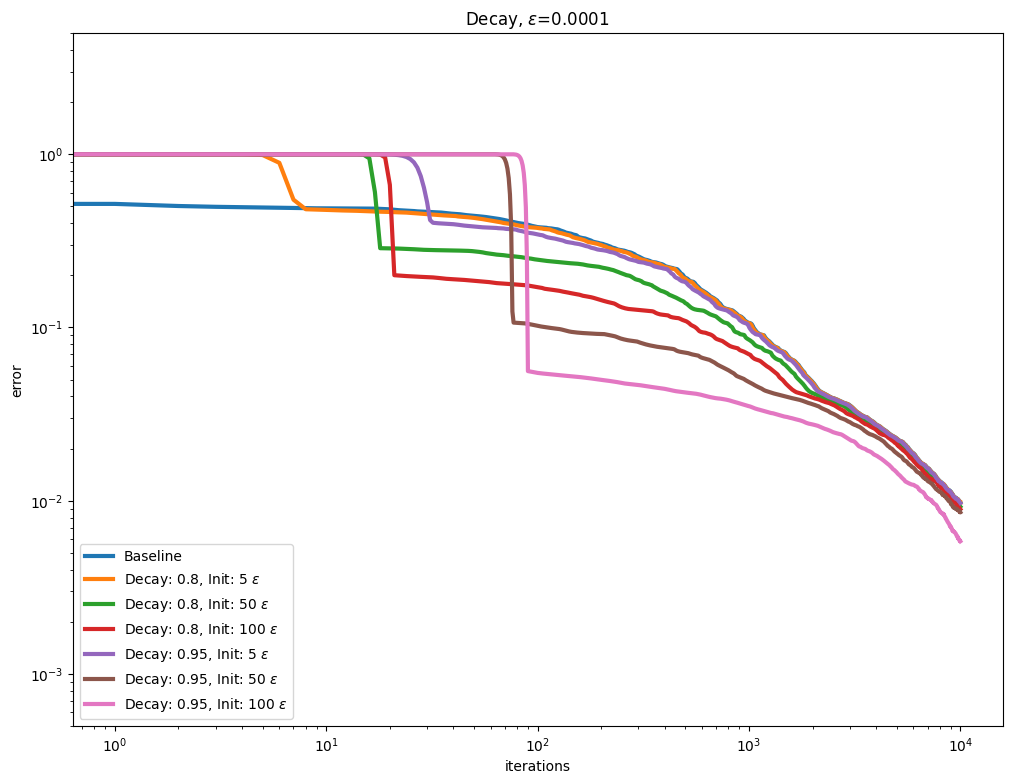

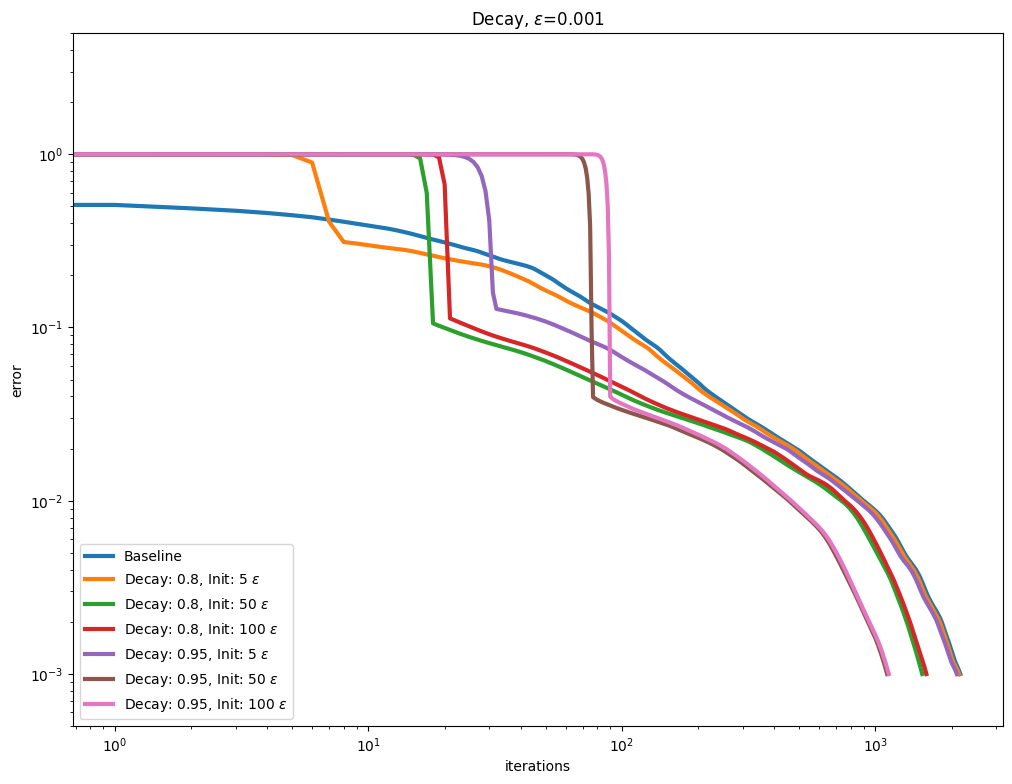

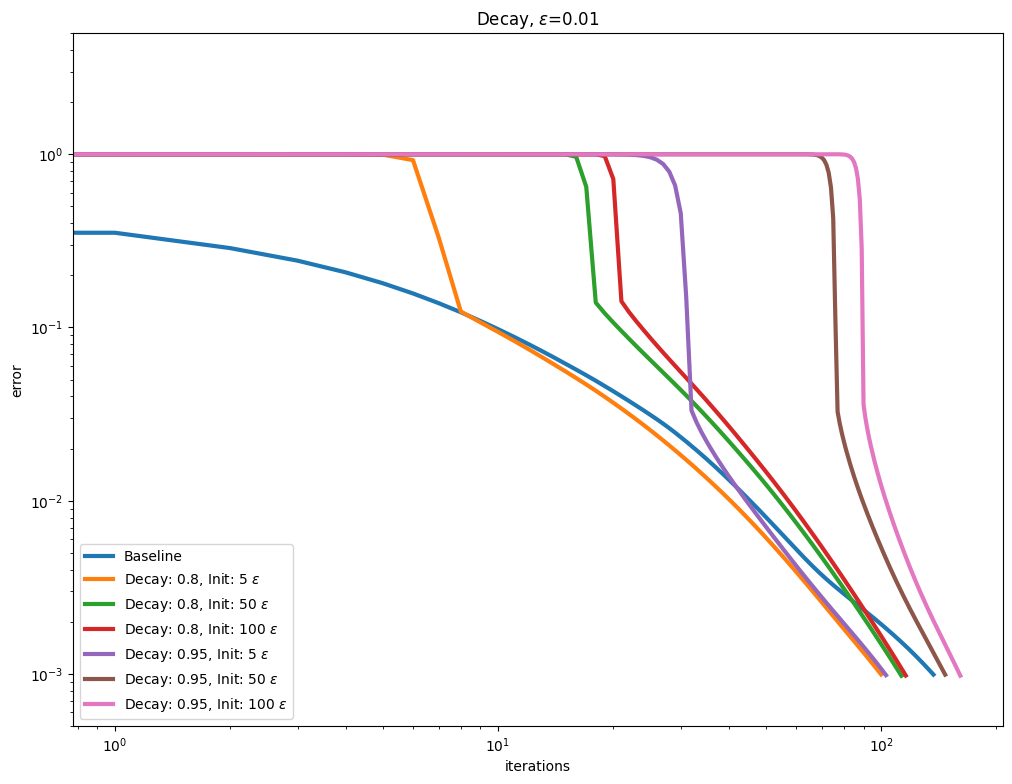

In [33]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_scaling[i],
        leg_scaling[i],
        title=rf"Decay, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

### Anderson acceleration

Using {class}`~ott.solvers.linear.acceleration.AndersonAcceleration` on the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm provides mixed results, worsening performance for smaller `epsilon` regularization, and slightly improving it as the regularization gets larger.

In [34]:
out_anderson, leg_anderson = [], []

for i, epsilon in enumerate(epsilons):
    out_anderson.append([out_baseline[i]])
    leg_anderson.append([leg_baseline[i]])
    for memory in [3, 5, 8, 15]:
        out_anderson[i].append(
            my_sinkhorn(
                geometry.Geometry(cost, epsilon=epsilon),
                a,
                b,
                anderson=acceleration.AndersonAcceleration(memory=memory),
            )
        )
        leg_anderson[i].append(f"Anderson Acceleration: {memory}")

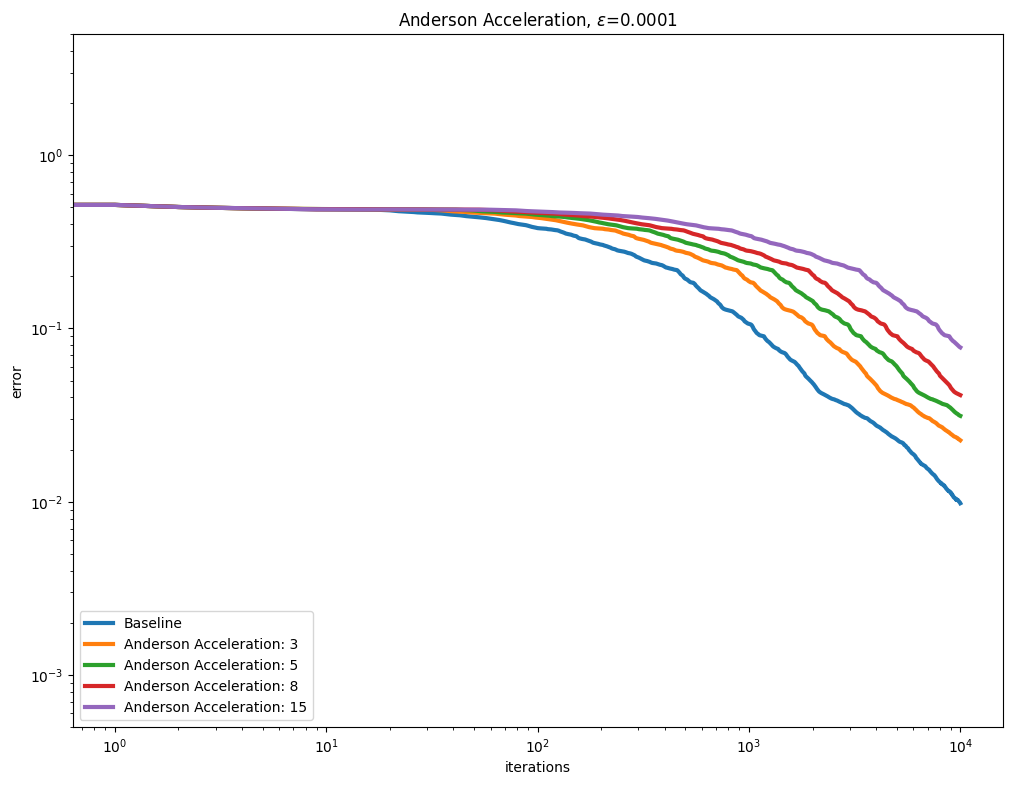

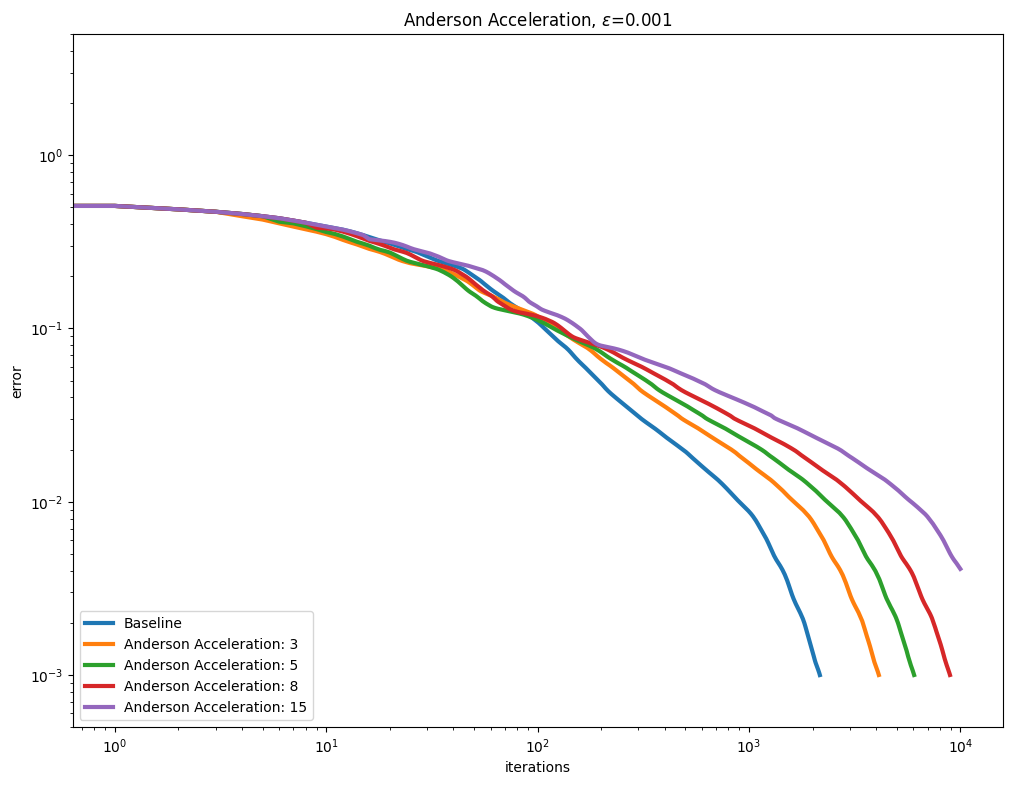

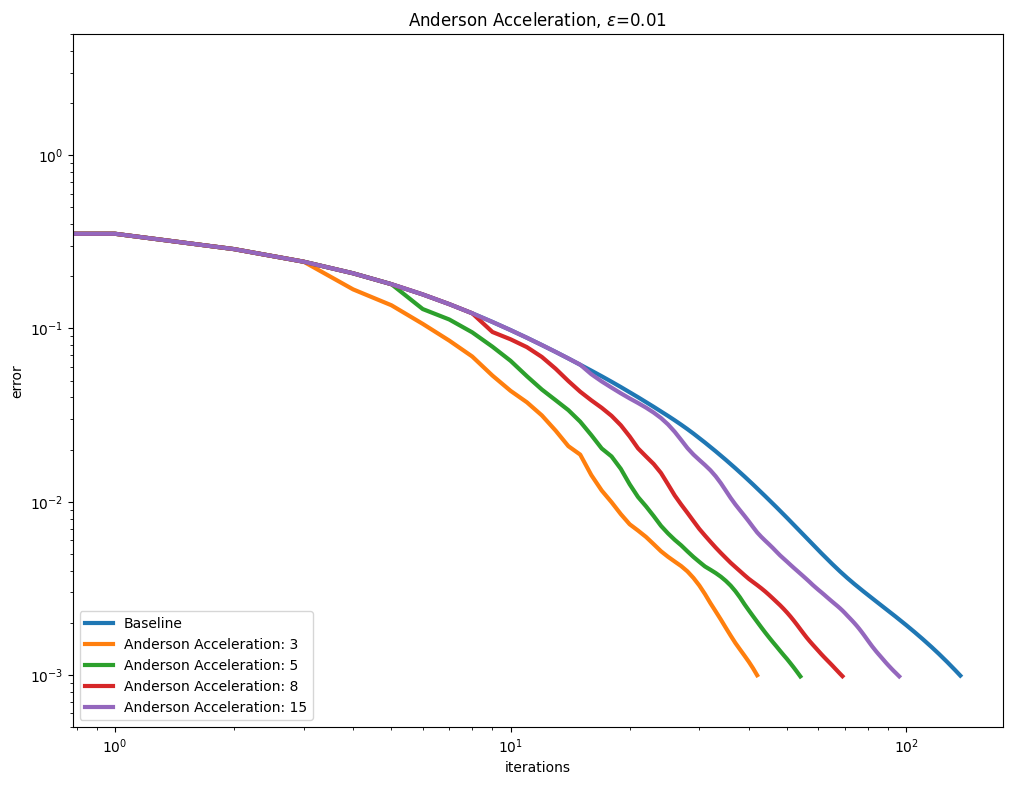

In [35]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_anderson[i],
        leg_anderson[i],
        title=r"Anderson Acceleration, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )

### Decay and momentum

An interesting direction to accelerate convergence is to update the {class}`~ott.solvers.linear.acceleration.Momentum` after the {class}`~ott.geometry.epsilon_scheduler.Epsilon` decay schedule has converged. 

In [36]:
out_mixed, leg_mixed = [], []
for i, epsilon in enumerate(epsilons):
    out_mixed.append([out_baseline[i]])
    leg_mixed.append([leg_baseline[i]])
    for decay, init, chg_momentum_from in [
        [0.5, 10, 10],
        [0.7, 5, 20],
        [0.9, 10, 50],
        [0.99, 2, 100],
    ]:
        Epsilon = geometry.epsilon_scheduler.Epsilon(
            target=epsilon, init=init, decay=decay
        )
        out_mixed[i].append(
            my_sinkhorn(
                geometry.Geometry(cost, epsilon=Epsilon),
                a,
                b,
                momentum=acceleration.Momentum(start=chg_momentum_from),
            )
        )
        leg_mixed[i].append(
            rf"Decay: {decay}, Init: {init}$\varepsilon$, ChgMom: {chg_momentum_from}"
        )

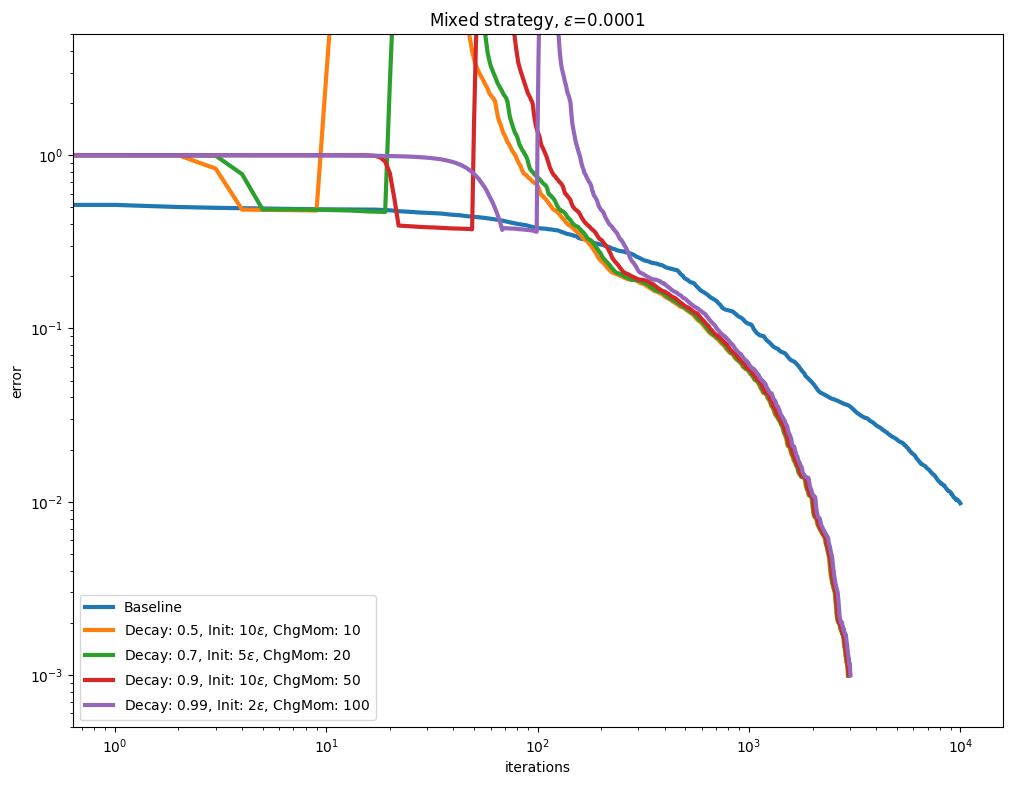

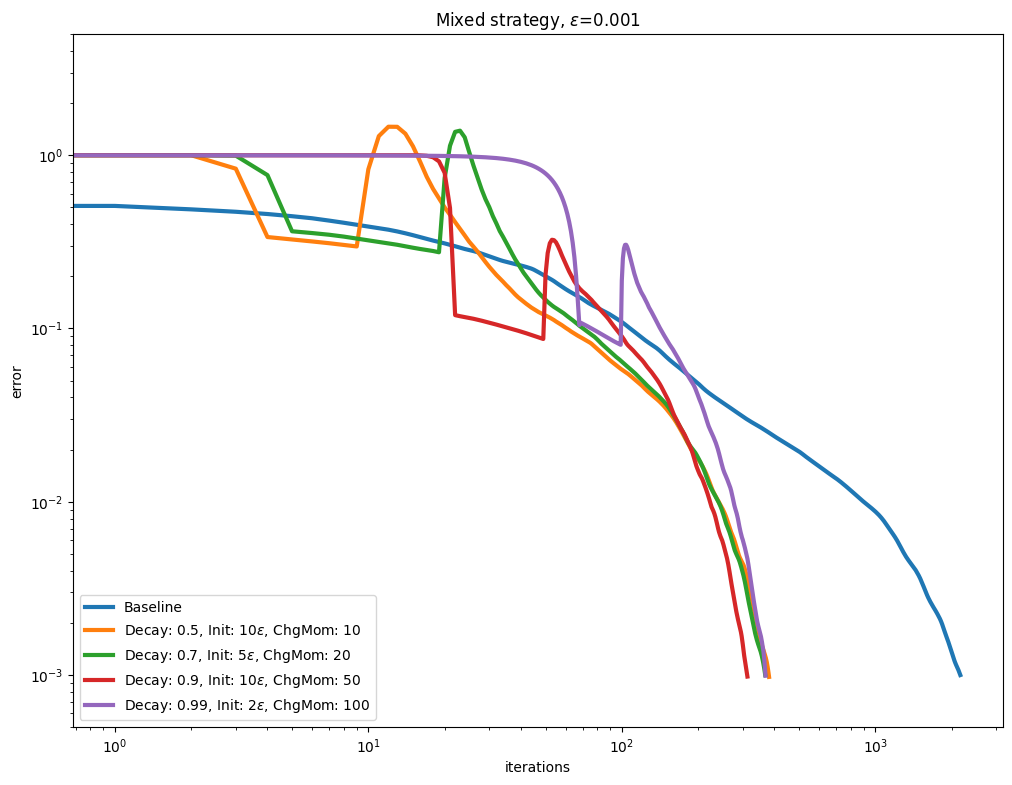

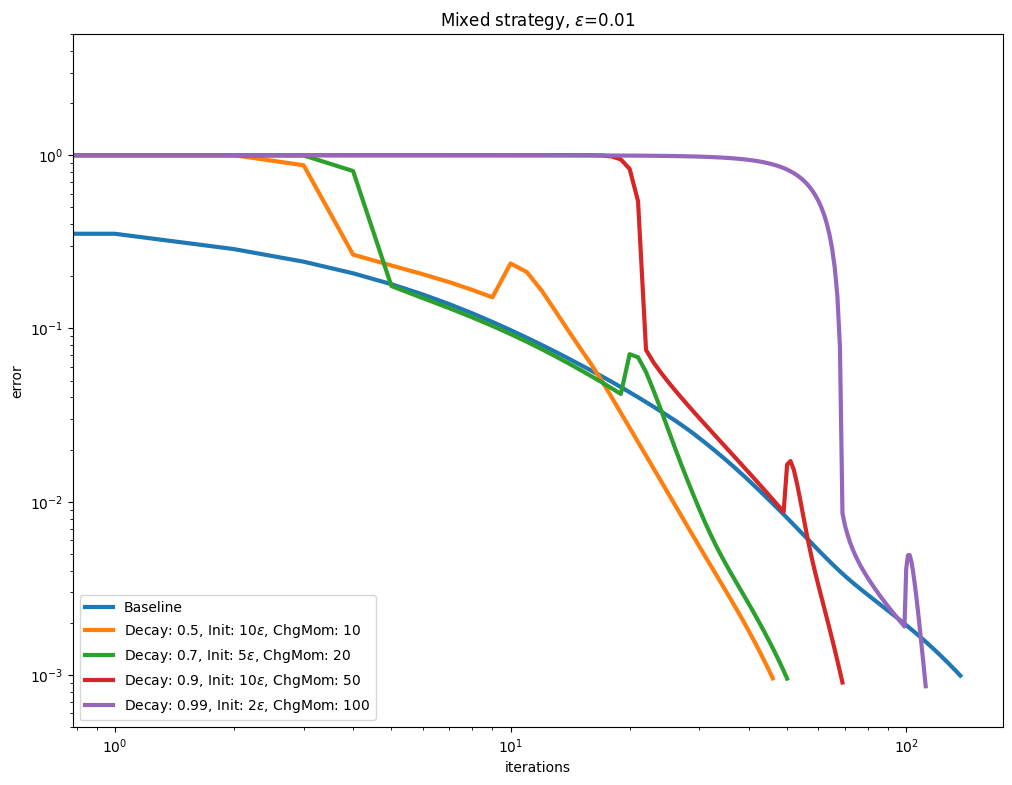

In [37]:
for i, epsilon in enumerate(epsilons):
    plot_results(
        out_mixed[i],
        leg_mixed[i],
        title=rf"Mixed strategy, $\varepsilon$=" + str(epsilon),
        xlabel="iterations",
        ylabel="error",
    )